## Week 4 - Introduction to Time Series Analysis and Forecasting
This notebook is mostly taken from [Mario Pexeiro's GitHub Repository "Time Series Forecasting with Python"](), freely released under the Apache licence.

In [ ]:
# Import necessary libraries

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [ ]:
# Open dataset by Pexeiro 

dataset_path = "https://raw.githubusercontent.com/marcopeix/TimeSeriesForecastingInPython/refs/heads/master/data/widget_sales.csv"

In [3]:
df = pd.read_csv(dataset_path)
df.head()

,widget_sales
0,50.496714
1,50.805493
2,51.477758
3,53.542228
4,54.873108


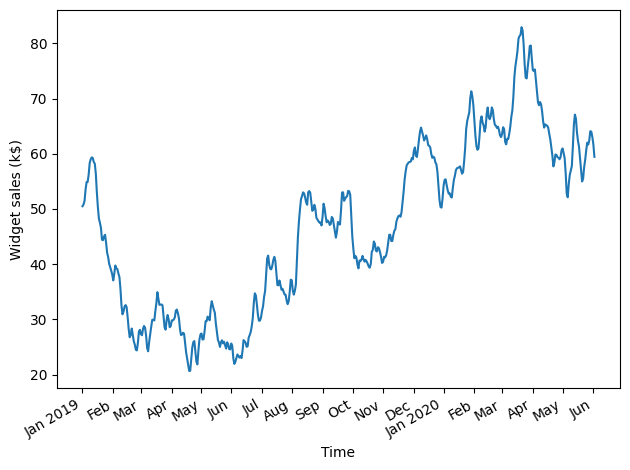

In [ ]:
fig, ax = plt.subplots()

ax.plot(df['widget_sales'])
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales (k$)')

# In this case, we (or Pexeiro :)) manually add the time references. They might directly be included in your dataset
plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan 2019', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan 2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])
fig.autofmt_xdate()
plt.tight_layout()

### 4.1 Perform ADF test to check **non-stationarity**

In [11]:
ADF_result = adfuller(df['widget_sales'])

#print(ADF_result)
print(f'ADF Statistic: {ADF_result[0]}')
#print(f'p-value: {ADF_result[1]}')
print("Critical Values:")
for key, value in ADF_result[4].items():
    print(f"   {key}: {value}")

ADF Statistic: -1.5121662069359048
Critical Values:
   1%: -3.4436029548776395
   5%: -2.867384756137026
   10%: -2.5698830308597813


In [12]:
widget_sales_diff = np.diff(df['widget_sales'], n=1)

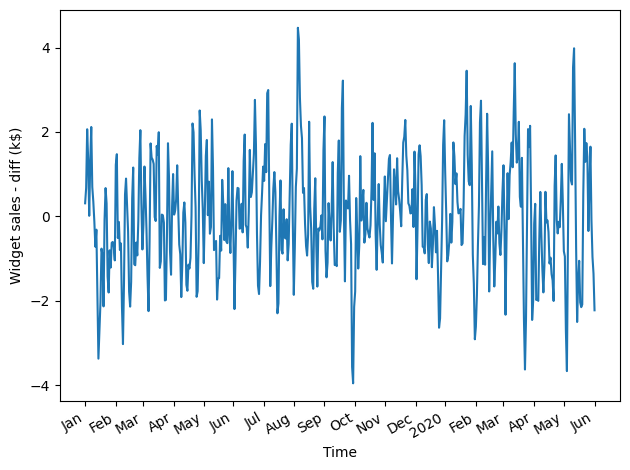

In [13]:
fig, ax = plt.subplots()

ax.plot(widget_sales_diff)
ax.set_xlabel('Time')
ax.set_ylabel('Widget sales - diff (k$)')

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()


In [14]:
ADF_result = adfuller(widget_sales_diff)

print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')

ADF Statistic: -10.576657780341959
p-value: 7.076922818587193e-19


### 4.2 Plot Autocorrelation Function and Partial Autocorrelation Function

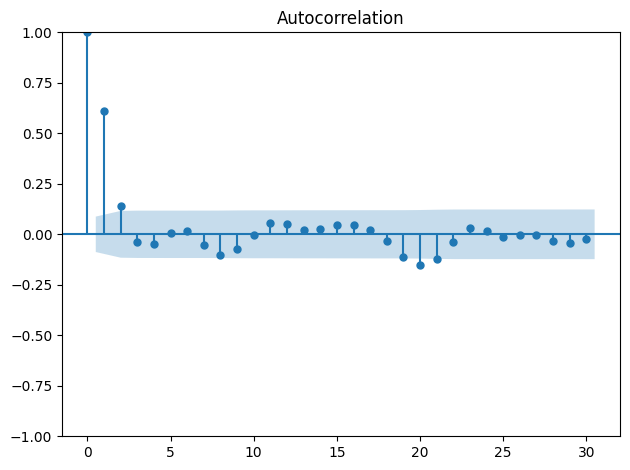

In [15]:
plot_acf(widget_sales_diff, lags=30);

plt.tight_layout()

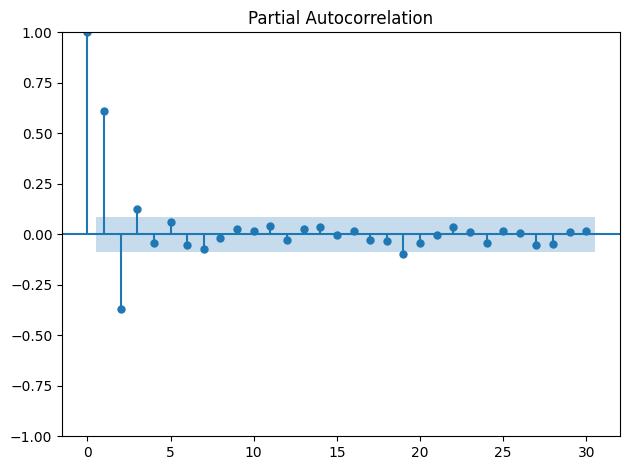

In [30]:
plot_pacf(widget_sales_diff, lags=30)
plt.tight_layout()

In [16]:
df_diff = pd.DataFrame({'widget_sales_diff': widget_sales_diff})

train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train))
print(len(test))

449
50


### 4.3 Recap
Here is a plot of the original time series vs the differentiated one.

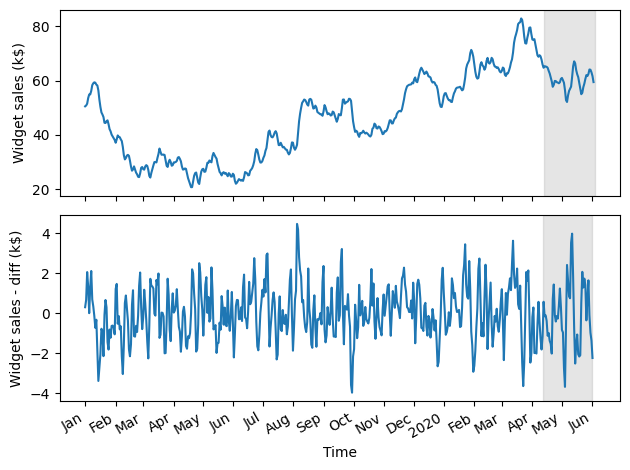

In [17]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True)

ax1.plot(df['widget_sales'])
ax1.set_xlabel('Time')
ax1.set_ylabel('Widget sales (k$)')
ax1.axvspan(450, 500, color='#808080', alpha=0.2)

ax2.plot(df_diff['widget_sales_diff'])
ax2.set_xlabel('Time')
ax2.set_ylabel('Widget sales - diff (k$)')
ax2.axvspan(449, 498, color='#808080', alpha=0.2)

plt.xticks(
    [0, 30, 57, 87, 116, 145, 175, 204, 234, 264, 293, 323, 352, 382, 409, 439, 468, 498], 
    ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', '2020', 'Feb', 'Mar', 'Apr', 'May', 'Jun'])

fig.autofmt_xdate()
plt.tight_layout()

### 4.4 Moving Average Model
We can use the ARIMA method in Python. ARIMA is a different (more extended) model. We can use this method in several ways by defining its parameters:

- p=0: no AR terms
- d=0: no differencing
- q=1: one MA term (= use the last error term)

In [33]:
#creating the model
MA_model = ARIMA(widget_sales_diff, order=(0, 0, 55))

#fitting data to the model
MA_results = MA_model.fit()

#summary of the model
print(MA_results.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  499
Model:                ARIMA(0, 0, 55)   Log Likelihood                -670.028
Date:                Wed, 22 Oct 2025   AIC                           1454.056
Time:                        18:05:11   BIC                           1694.175
Sample:                             0   HQIC                          1548.286
                                - 499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0298      0.069      0.430      0.667      -0.106       0.166
ma.L1          0.9055      0.053     17.240      0.000       0.803       1.008
ma.L2          0.3334      0.069      4.824      0.0

You might need to revise some contents from **lecture 1 about EDA**. Not all of this information is relevant for you - you can look at the p-value to see if the result is significant (lower p-value = more significant).

In [ ]:
# Forecast next 10 steps
forecast_steps = 10
forecast = MA_results.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
print(forecast_mean)
forecast_ci = forecast.conf_int()  # confidence intervals

[-0.32125048  0.96356562  0.25552394  0.09360232  0.09723439 -0.08726095
  0.62926542  0.51925561  0.02033909  0.01666124]


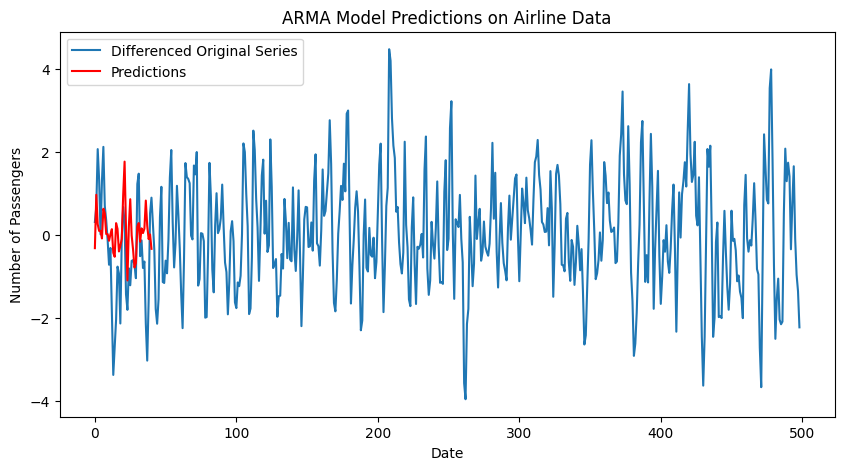

In [ ]:
# snippet from https://www.geeksforgeeks.org/data-science/arma-time-series-model/

start = len(widget_sales_diff)
end = start + 40
predictions = MA_results.predict(start=start, end=end)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(widget_sales_diff, label='Differenced Original Series')
plt.plot(predictions, label='Predictions', color='red')
plt.legend()
plt.title('ARMA Model Predictions on Airline Data')
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.show()

### 4.5 ARMA model

In [ ]:
# Fit ARMA(2,1) model
arma_model = ARIMA(widget_sales_diff, order=(2,0,1))  # 2 autoregressive terms, uses the last 2 observed values
arma_result = arma_model.fit()

print(arma_result.summary())

# Forecast next 5 steps
forecast_arma = arma_result.forecast(steps=5)
print("ARMA Forecast:\n", forecast_arma)

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  499
Model:                 ARIMA(2, 0, 1)   Log Likelihood                -697.461
Date:                Wed, 22 Oct 2025   AIC                           1404.922
Time:                        17:51:31   BIC                           1425.985
Sample:                             0   HQIC                          1413.188
                                - 499                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0152      0.094      0.162      0.872      -0.169       0.199
ar.L1          0.4998      0.109      4.592      0.000       0.286       0.713
ar.L2         -0.1604      0.081     -1.977      0.0

### 4.6 Autoregressive model

In [24]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR model (lag=3)
ar_model = AutoReg(widget_sales_diff, lags=3)
ar_result = ar_model.fit()

# Print summary
print(ar_result.summary())

# Forecast next 5 steps
forecast_ar = ar_result.predict(start=len(widget_sales_diff), end=len(widget_sales_diff)+4)
print("AR Forecast:\n", forecast_ar)

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                  499
Model:                     AutoReg(3)   Log Likelihood                -694.005
Method:               Conditional MLE   S.D. of innovations              0.980
Date:                Wed, 22 Oct 2025   AIC                           1398.011
Time:                        17:51:24   BIC                           1419.044
Sample:                             3   HQIC                          1406.267
                                  499                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.044      0.044      0.965      -0.084       0.088
y.L1           0.8865      0.044     19.925      0.000       0.799       0.974
y.L2          -0.4800      0.056     -8.626      0.0